In [1]:
from PINNs import *
import torch
import numpy as np
import matplotlib.pyplot as plt
from smt.sampling_methods import LHS
dtype=torch.float64
setup_seed(2)
Ts = 0
Te = 0.32
#Te = 0.1
Xs = 0
Xe = 1
Nx = 100
Nt = 100
dt = 0.002
dx = 0.01

crhoL =1.0
cuL = 0.0
cpL = 0.01

crhoR = 1.0
cuR = 0
cpR = 0.01
setup_seed(7)
def train(epoch):
    def closure():
        optimizer.zero_grad()                                                     
        loss_pde = model.loss_pde(x_int)                                    
        loss_ic = model.loss_ic(x_ic, rho_ic,u_ic,p_ic)   
        loss_bc = model.loss_ic(x_bc, rho_bc,u_bc,p_bc)   
        
        loss_rh = model.loss_rh(xrh,xrhL) # RH relation
        loss_con = model.loss_con(x_en,x_ic,crhoL,cuL,cpL,crhoR,cuR,cpR,Te-Ts) #Conservation laws
        loss_con1 = model.loss_con(x_en1,x_ic,crhoL,cuL,cpL,crhoR,cuR,cpR,Te/2) #Conservation laws
        loss_con2 = model.loss_con(x_en2,x_ic,crhoL,cuL,cpL,crhoR,cuR,cpR,Te/10) #Conservation laws
        loss = loss_pde + 10*(loss_ic+loss_bc) + 10*(loss_rh) +10*(loss_con +loss_con1+loss_con2)
        print(f'epoch {epoch} loss_pde:{loss_pde:.8f}, loss_ic:{loss_ic:.8f}, loss_rh:{loss_rh:.8f},loss_con:{loss_con:.8f}')
        loss.backward()
        return loss
    loss = optimizer.step(closure)
    return loss

#x_ic,x_bc,x_int =  Mesh_Data(Nx,Nt,Ts,Te,Xs,Xe)

xlimits = np.array([[0.,0],[0, Xe]])  #interal
sampling = LHS(xlimits=xlimits)
x_ic= sampling(1000)

xlimits = np.array([[0.1,Te],[0, 0]])  #interal
sampling = LHS(xlimits=xlimits)
x_bcL= sampling(100)
xlimits = np.array([[0.,Te],[Xe, Xe]])  #interal
sampling = LHS(xlimits=xlimits)
x_bcR= sampling(100)
x_bc = np.vstack((x_bcL,x_bcR))

rho_ic, u_ic, p_ic= IC_Blast(x_ic)                    
rho_bc, u_bc, p_bc= IC_Riemann_1D(x_bc,crhoL,cuL,cpL,crhoR,cuR,cpR)                    
xlimits = np.array([[0.0,Te],[0, Xe]])  #interal
sampling = LHS(xlimits=xlimits)
x_int= sampling(10000)

xrh,xrhL,xrhR,xrhP,xrhPL,xrhPR = Pertur_1D(x_int,0,dt,dx)

x_en = Move_Time_1D(x_ic,Te)
x_en1 = Move_Time_1D(x_ic,Te/2)
x_en2 = Move_Time_1D(x_ic,Te/10)

x_ic = torch.tensor(x_ic,dtype=dtype).to(cuda)
x_bc = torch.tensor(x_bc,dtype=dtype).to(cuda)
x_int = torch.tensor(x_int,requires_grad=True, dtype=dtype).to(cuda)
x_en = torch.tensor(x_en,  dtype=dtype).to(cuda)
x_en1 = torch.tensor(x_en1,  dtype=dtype).to(cuda)
x_en2 = torch.tensor(x_en2,  dtype=dtype).to(cuda)
xrh = torch.tensor(xrh,  dtype=dtype).to(cuda)
xrhL = torch.tensor(xrhL,  dtype=dtype).to(cuda)

rho_ic = torch.tensor(rho_ic, dtype=dtype).to(cuda)
u_ic = torch.tensor(u_ic, dtype=dtype).to(cuda)
p_ic = torch.tensor(p_ic, dtype=dtype).to(cuda)

rho_bc = torch.tensor(rho_bc, dtype=dtype).to(cuda)
u_bc = torch.tensor(u_bc, dtype=dtype).to(cuda)
p_bc = torch.tensor(p_bc, dtype=dtype).to(cuda)

In [2]:
e = 16e6
p = 0.4*e
rhoL = 1
uL = 0
pL =  100 
rhoR =1
uR = 0
pR = 1
t = 0.038

rhoLn,uLn,pLn,rhoRn,uRn,pRn, tn,rhoref,uref,pref =Unit_var(rhoL,uL,pL,rhoR,uR,pR,t)

In [3]:
tn

0.38

In [4]:
model = PINNs_WE_Euler_1D(Nl=6,Nn=60).to(cuda).double()
print('Start training...')
epoch = 0
epochi = epoch
lr = 0.001                                                           # Learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs = 100000
loss_history=[]
tic = time.time()
for epoch in range(1+epochi, epochs+epochi):
    loss = train(epoch)
    print(f'loss_tot:{loss:.8f}')
    loss_history.append(to_numpy(loss))
    if loss < 0.05:
        break
toc = time.time()
print(f'Total training time: {toc - tic}')



Start training...
epoch 1 loss_pde:0.01350261, loss_ic:1.38328192, loss_rh:0.00000000,loss_con:0.00161490
loss_tot:25.38086143
epoch 2 loss_pde:0.01112648, loss_ic:1.21884413, loss_rh:0.00000000,loss_con:0.00133234
loss_tot:22.08817228
epoch 3 loss_pde:0.00950705, loss_ic:1.06711554, loss_rh:0.00000000,loss_con:0.00112660
loss_tot:19.05370689
epoch 4 loss_pde:0.00844586, loss_ic:0.92144450, loss_rh:0.00000000,loss_con:0.00098144
loss_tot:16.14588423
epoch 5 loss_pde:0.00791015, loss_ic:0.77807702, loss_rh:0.00000000,loss_con:0.00089986
loss_tot:13.29357126
epoch 6 loss_pde:0.00784138, loss_ic:0.63685916, loss_rh:0.00000000,loss_con:0.00088379
loss_tot:10.49682985
epoch 7 loss_pde:0.00810881, loss_ic:0.50118664, loss_rh:0.00000000,loss_con:0.00093108
loss_tot:7.82685397
epoch 8 loss_pde:0.00850177, loss_ic:0.37799999, loss_rh:0.00000000,loss_con:0.00103398
loss_tot:5.42663371
epoch 9 loss_pde:0.00876907, loss_ic:0.27746355, loss_rh:0.00000000,loss_con:0.00117904
loss_tot:3.50429411
epoc

In [ ]:
optimizer = torch.optim.LBFGS(model.parameters(),lr=0.1,max_iter=20)

epochi = 0

epochs = 5000
tic = time.time()
for epoch in range(epochi, epochs+epochi):
    loss = train(epoch)
    print(f'loss_tot:{loss:.8f}')
    loss_history.append(to_numpy(loss))
  #  if loss < 0.005:
   #     break
toc = time.time()

print(f'Total training time: {toc - tic}')

epoch 0 loss_pde:0.03502319, loss_ic:0.00171001, loss_rh:0.00030812,loss_con:0.00023354
epoch 0 loss_pde:15.73609997, loss_ic:0.00174425, loss_rh:0.00035568,loss_con:0.00018172
epoch 0 loss_pde:9.75902481, loss_ic:0.00173792, loss_rh:0.00035728,loss_con:0.00018629
epoch 0 loss_pde:8.93144421, loss_ic:0.00173684, loss_rh:0.00035725,loss_con:0.00018713
epoch 0 loss_pde:8.03492489, loss_ic:0.00173560, loss_rh:0.00035707,loss_con:0.00018814
epoch 0 loss_pde:7.23207778, loss_ic:0.00173440, loss_rh:0.00035675,loss_con:0.00018913
epoch 0 loss_pde:6.50735496, loss_ic:0.00173324, loss_rh:0.00035627,loss_con:0.00019013
epoch 0 loss_pde:5.85345606, loss_ic:0.00173212, loss_rh:0.00035566,loss_con:0.00019112
epoch 0 loss_pde:5.26351982, loss_ic:0.00173103, loss_rh:0.00035490,loss_con:0.00019211
epoch 0 loss_pde:4.73136626, loss_ic:0.00172998, loss_rh:0.00035401,loss_con:0.00019311
epoch 0 loss_pde:4.25141662, loss_ic:0.00172896, loss_rh:0.00035300,loss_con:0.00019409
epoch 0 loss_pde:3.81863391, lo

KeyboardInterrupt: 

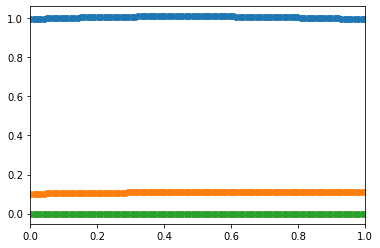

In [ ]:
x = np.linspace(0.0, 1.0, 100)                                   
t = np.linspace(Te, Te, 1)                                     
t_grid, x_grid = np.meshgrid(t, x)                               
T = t_grid.flatten()[:, None]                                    
X = x_grid.flatten()[:, None]                                    
x_test = np.hstack((T, X))                                       
x_test = torch.tensor(x_test, dtype=dtype).to(cpu)
u_pred = to_numpy(model(x_test))

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(x[:],u_pred[:,0])
ax.scatter(x[:],u_pred[:,1])
ax.scatter(x[:],u_pred[:,2])
#ax.plot(Exact[:,0],Exact[:,1])
#ax.plot(Exact[:,0],Exact[:,2])
#ax.plot(Exact[:,0],Exact[:,3])
ax.set_xlim(0.0, 1.0)
#ax.set_ylim(0.2, 1.2)
plt.show()

In [ ]:
Exact = np.loadtxt('sode.dat')
Exact[:,0]

array([0.02671362, 0.02789683, 0.02908005, ..., 1.19560583, 1.19735798,
       1.19911014])

In [ ]:
device = cpu

x = np.linspace(0.0, 1.0, 100)                                   
t = np.linspace(Te,  Te, 1)                                     
t_grid, x_grid = np.meshgrid(t, x)                               
T = t_grid.flatten()[:, None]                                    
X = x_grid.flatten()[:, None]                                    
x_test = np.hstack((T, X))                                       
x_1,xL,xR,xP,xPL,xPR = Pertur_1D(x_test,0.00,0.01,0.01)
x_test = torch.tensor(x_test, requires_grad=True, dtype=dtype).to(device)
xR = torch.tensor(xR, dtype=dtype).to(device)
xL = torch.tensor(xL, dtype=dtype).to(device)
u_pred = model(x_test)
uL_pred = model(xL)
uR_pred = model(xR)
rho, p,u = u_pred[:, 0], u_pred[:, 1], u_pred[:, 2]          
rhoL, pL,uL = uL_pred[:, :1], uL_pred[:, 1:2], uL_pred[:, 2:]          
rhoR, pR,uR = uR_pred[:, :1], uR_pred[:, 1:2], uR_pred[:, 2:]          
U2 = rho*u
U3 = 0.5*rho*u**2 + p/0.4

#F1 = U2
F2 = rho*u**2+p
F3 = u*(U3 + p)

gamma = 1.4                                                    

# Gradients and partial derivatives
drho_g = gradients(rho, x_test)[0]                                  
rho_t, rho_x = drho_g[:, :1], drho_g[:, 1:]             


du_g = gradients(u, x_test)[0]                                      
u_t, u_x = du_g[:, :1], du_g[:, 1:]                            

dp_g = gradients(p, x_test)[0]                                      
p_t, p_x = dp_g[:, :1], dp_g[:, 1:]                            

dp_g = gradients(p, x_test)[0]                                     
p_t, p_x = dp_g[:, :1], dp_g[:, 1:]                           

dU2_g = gradients(U2, x_test)[0]
U2_t,U2_x = dU2_g[:,:1], dU2_g[:,1:]
dU3_g = gradients(U3, x_test)[0]
U3_t,U3_x = dU3_g[:,:1], dU3_g[:,1:]
dF2_g = gradients(F2, x_test)[0]
F2_t,F2_x = dF2_g[:,:1], dF2_g[:,1:]
dF3_g = gradients(F3, x_test)[0]
F3_t,F3_x = dF3_g[:,:1], dF3_g[:,1:]

d = 0.2*(abs(u_x)-(u_x))  + 1

d = 0.1*(abs(uR-uL)-(uR-uL))/0.01 + 1
#d = torch.exp(-10*u_x)+1
#d1 = torch.clamp(d/5,min=1)

d = 1/(0.2*(abs(u_x)-u_x)+1)
d2 =1/(0.1*(abs(uR-uL)-(uR-uL))/0.02  + 1)
f = ((rho_t + U2_x))**2 + \
    ((U2_t  + F2_x))**2 + \
    ((U3_t  + F3_x))**2 #+\
#d = 1/(0.1*(torch.clamp((abs(u_x)-u_x))
d = to_numpy(d)
d2 = to_numpy(d2)
f = to_numpy(f)
#d3 = to_numpy(d3)
u_pred = to_numpy(u_pred)

np.size(u_pred[:,0])

100

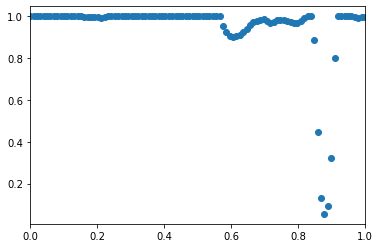

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
#ax.scatter(x[:],rhoref*u_pred[:,0])
#ax.scatter(x[:],pref*u_pred[:,1])
#ax.scatter(x[:],uref*u_pred[:,2])
ax.scatter(x[:],d)
#ax.scatter(x[:],d2)
#ax.scatter(x[:],f)
#ax.plot(Exact[:,0],Exact[:,1],color='black')
#ax.plot(Exact[:,0],Exact[:,2],color='black')
#ax.plot(Exact[:,0],Exact[:,3],color='black')
ax.set_xlim(0.0, 1.0)
#plt.savefig('1.eps', format='eps')
#ax.set_ylim(0.0, 1.2)
#ax.scatter(x[:],d)
plt.show()

In [ ]:
xp= x.flatten()[:,None]
rhop= u_pred[:,0].flatten()[:,None]
up= u_pred[:,1].flatten()[:,None]
pp= u_pred[:,2].flatten()[:,None]
ff= f.flatten()[:,None]
dd= d.flatten()[:,None]
uxy= np.hstack((xp,rhop,up,pp,ff,dd))
np.savetxt('Sod_DuringTrain.dat', uxy)

In [ ]:
xp= x.flatten()[:,None]
rhop= u_pred[:,0].flatten()[:,None]
up= u_pred[:,1].flatten()[:,None]
pp= u_pred[:,2].flatten()[:,None]
uxy= np.hstack((xp,rhop,up,pp))    
np.savetxt('Sod.dat', uxy)